# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from testing import Tester

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [5]:
openai = OpenAI()

In [7]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('../week6/test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [8]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [9]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [10]:
DB = "products_vectorstore"

In [11]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [12]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [13]:
description(test[0])

"Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [14]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [15]:
def vector(item):
    return model.encode([description(item)])

In [16]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [17]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

TUAIC Refrigerator Door Light Switch 2 Feet for GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef
Production Name TUAIC Refrigerator Door Light Switch 2 Feet. Rated Voltage AC, Rated Current 2.5A 125V, Work Temperature Control Type NC(normally close, most refrigerator control type),Connect Pin Size Universal and compatible design, replace for most Whirlpool, Maytag,Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef refrigerators' door light switch. Production Name TUAIC Refrigerator Door Light Switch 2 Feet. Rated Voltage AC, Rated Current 2.5A 125

Price is $10.00


In [18]:
documents, prices = find_similars(test[1])

In [19]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
TUAIC Refrigerator Door Light Switch 2 Feet For GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef
Production Name Refrigerator Door Light Switch, Rated Voltage AC, Rated Current 2.5A 125V, Work Temperature Type NC(normally close, most refrigerator control type),Connect Pin Size Universal and compatible design, replace for most Whirlpool, Maytag,Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef refrigerators' door light switch. ✅Production Name Refrigerator Door Light Switch, Rated Voltage AC, Rated Current 2.5A 125V, Work Temperature Type NC(normally close, most
Price is $9.68

Potentially related product:
Refrigerator Door Light Switch 2 Feet For GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef
Production Name TUAIC Refrigerator Door Light Switch, Rated Vo

In [ ]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nTUAIC Refrigerator Door Light Switch 2 Feet For GE Whirlpool, Maytag, Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef\nProduction Name Refrigerator Door Light Switch, Rated Voltage AC, Rated Current 2.5A 125V, Work Temperature Type NC(normally close, most refrigerator control type),Connect Pin Size Universal and compatible design, replace for most Whirlpool, Maytag,Admiral, Amana, Crosley, Jenn-Air, Kenmore, KitchenAid, Magic Chef refrigerators' door light switch. ✅Production Name Refrigerator Door Light Switch, Rated Voltage AC, Rated Current 2.5A 125V, Work Temperature Type NC(normally close, most\nPrice is $9.68\n\nPotentially related product:\nRefrigerator Door Light Switch 2 Feet For GE Whir

In [ ]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [ ]:
get_price("The price for this is $99.99")

99.99

In [ ]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
gpt_4o_mini_rag(test[1])

9.68

In [ ]:
test[1].price

9.68

1: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $9.68 Truth: $9.68 Error: $0.00 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $312.99 Truth: $155.98 Error: $157.01 SLE: 0.48 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $5.99 Truth: $5.59 Error: $0.40 SLE: 0.00 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $74.99 Truth: $98.40 Error: $23.41 SLE: 0.07 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $29.99 Truth: $54.99 Error: $25.00 SLE: 0.35 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $8.99 Truth: $5.71 Error: $3.28 SLE: 0.16 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $14.99 Truth: $9.53 Error: $5.46 SLE: 0.17 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $12.95 Truth: $11.24 Error: $1.71 SLE: 0.02 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $16.95 Truth: $12.88 Error: $4.07 SLE: 0.07 Item: Away NV350 NV351

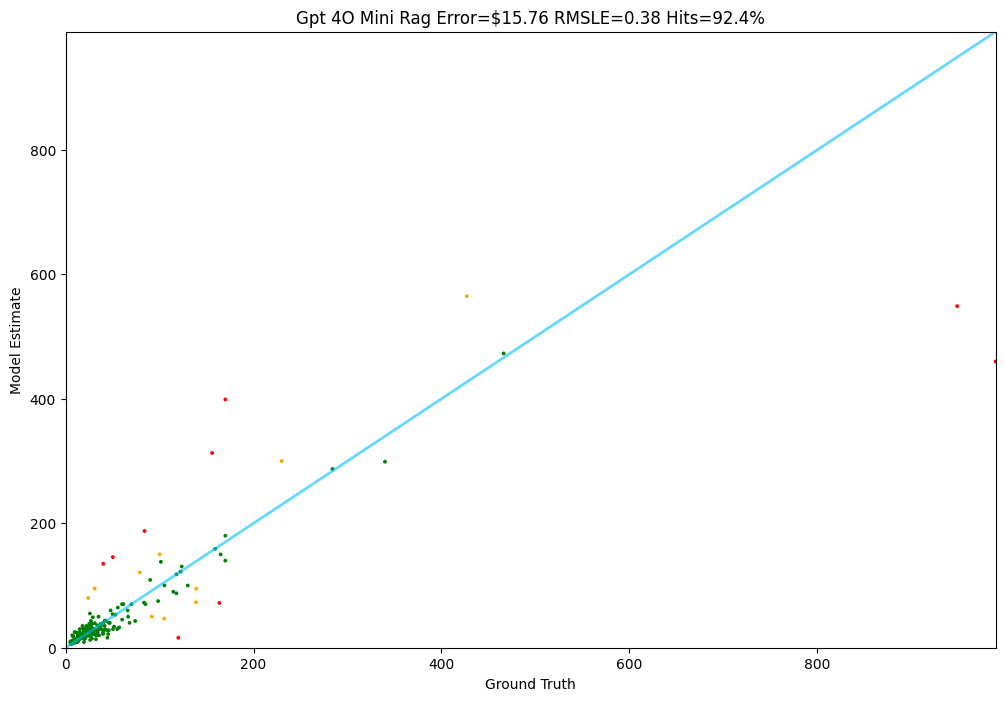

In [26]:
Tester.test(gpt_4o_mini_rag, test)

## Optional Extra: Trying a DeepSeek API call instead of OpenAI

If you have a DeepSeek API key, we will use it here as an alternative implementation; otherwise skip to the next section..

In [27]:
# Connect to DeepSeek using the OpenAI client python library

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [28]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

def deepseek_api_rag(item):
    documents, prices = find_similars(item)
    retries = 8
    done = False
    while not done and retries > 0:
        try:
            response = deepseek_via_openai_client.chat.completions.create(
                model="deepseek-chat", 
                messages=messages_for(item, documents, prices),
                seed=42,
                max_tokens=8
            )
            reply = response.choices[0].message.content
            done = True
        except Exception as e:
            print(f"Error: {e}")
            retries -= 1
    return get_price(reply)

In [29]:
deepseek_api_rag(test[1])

9.68

1: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $9.68 Truth: $9.68 Error: $0.00 SLE: 0.00 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $199.99 Truth: $155.98 Error: $44.01 SLE: 0.06 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $5.59 Truth: $5.59 Error: $0.00 SLE: 0.00 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $0.00 Truth: $98.40 Error: $98.40 SLE: 21.15 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $39.99 Truth: $54.99 Error: $15.00 SLE: 0.10 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $8.99 Truth: $5.71 Error: $3.28 SLE: 0.16 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $15.99 Truth: $9.53 Error: $6.46 SLE: 0.23 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $10.99 Truth: $11.24 Error: $0.25 SLE: 0.00 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $14.99 Truth: $12.88 Error: $2.11 SLE: 0.02 Item: Away NV350 NV351 

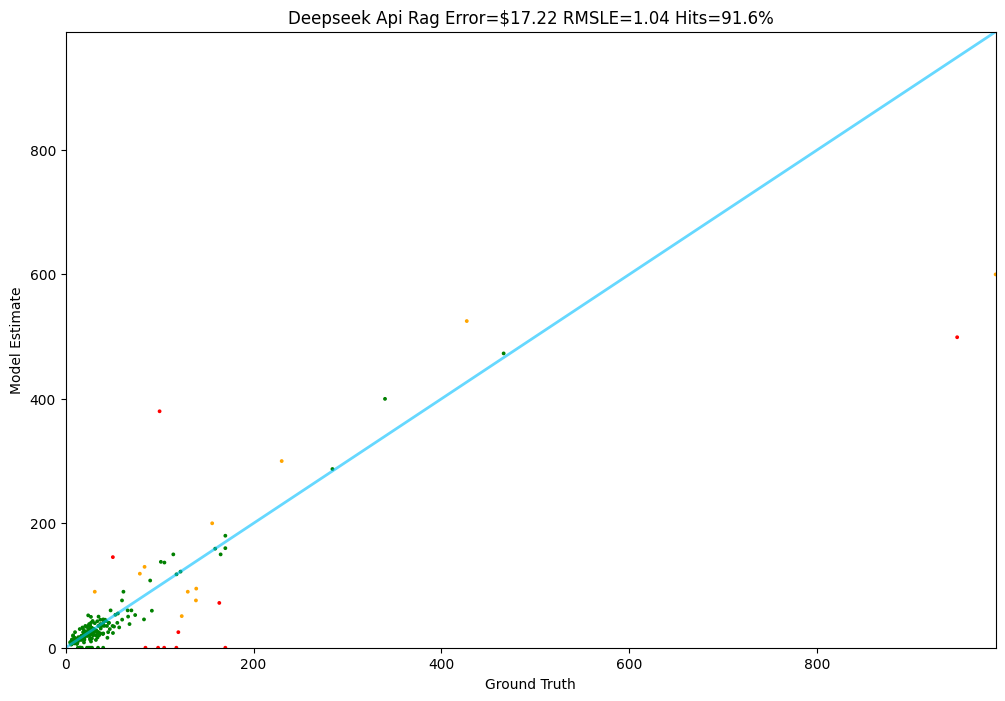

In [30]:
Tester.test(deepseek_api_rag, test)

## And now to wrap this in an "Agent" class

In [31]:
from agents.frontier_agent import FrontierAgent

In [32]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [33]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is set up with DeepSeek
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [34]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call deepseek-chat with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $139.99


139.99

In [35]:
from agents.specialist_agent import SpecialistAgent

In [36]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
INFO:root:[Specialist Agent] Specialist Agent is ready


In [37]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Specialist Agent] Specialist Agent is calling remote fine-tuned model
INFO:root:[Specialist Agent] Specialist Agent completed - predicting $150.00


150.0